This Colab Notebook demonstrates InstantStyle and ControlNet usage on SDXL model.

## Install dependency

In [11]:
# !mkdir -p ../image_encoder

# # Download IP-Adapter model checkpoints
# # !wget -P ../sdxl_models/ https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/ip-adapter_sdxl.bin
# # !wget -P ../sdxl_models/ https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/ip-adapter-plus_sdxl_vit-h.bin

# # Download image_encoder model checkpoints
# !wget -O ../image_encoder/pytorch_model.bin https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/image_encoder/pytorch_model.bin
# !wget -O ../image_encoder/config.json https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/image_encoder/config.json




--2024-05-04 02:48:29--  https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/image_encoder/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 13.33.30.23, 13.33.30.114, 13.33.30.49, ...
Connecting to huggingface.co (huggingface.co)|13.33.30.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/6f/e5/6fe5d8840a1ab462e1b9f52fbeabac6bb30febaf56fb5a439f08cca6d1cf4372/2999562fbc02f9dc0d9c0acb7cf0970ec3a9b2a578d7d05afe82191d606d2d80?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1715050110&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTA1MDExMH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy82Zi9lNS82ZmU1ZDg4NDBhMWFiNDYyZTFiOWY1MmZiZWFiYWM2YmIzMGZlYmFmNTZmYjVhNDM5ZjA4Y2NhNmQxY2Y0MzcyLzI5OTk1NjJmYmMwMmY5ZGMwZ

In [2]:
# # Install required python modules
# !pip install diffusers transformers torch einops accelerate

# # Clone the repository
# !git clone https://github.com/InstantStyle/InstantStyle.git  /content/InstantStyle


## Init

In [3]:
!ls

instant_style_controlnet_sdxl_demo.ipynb


In [4]:
import sys
import os
sys.path.append("../../InstantStyle")
print(sys.path)

from PIL import Image

import torch
from ip_adapter import IPAdapterXL
from PIL import Image

print("DONE: modules required")

['/home/jupyter/image_to_video/InstantStyle/notebooks', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/home/jupyter/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '../../InstantStyle']


2024-05-04 02:46:47.379688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 02:46:47.443466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


DONE: modules required


In [5]:

base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
image_encoder_path = "../image_encoder"
ip_ckpt = "../sdxl_models/ip-adapter_sdxl.bin"
device = "cuda"


In [6]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid



## Use Instant Style with Control Net  

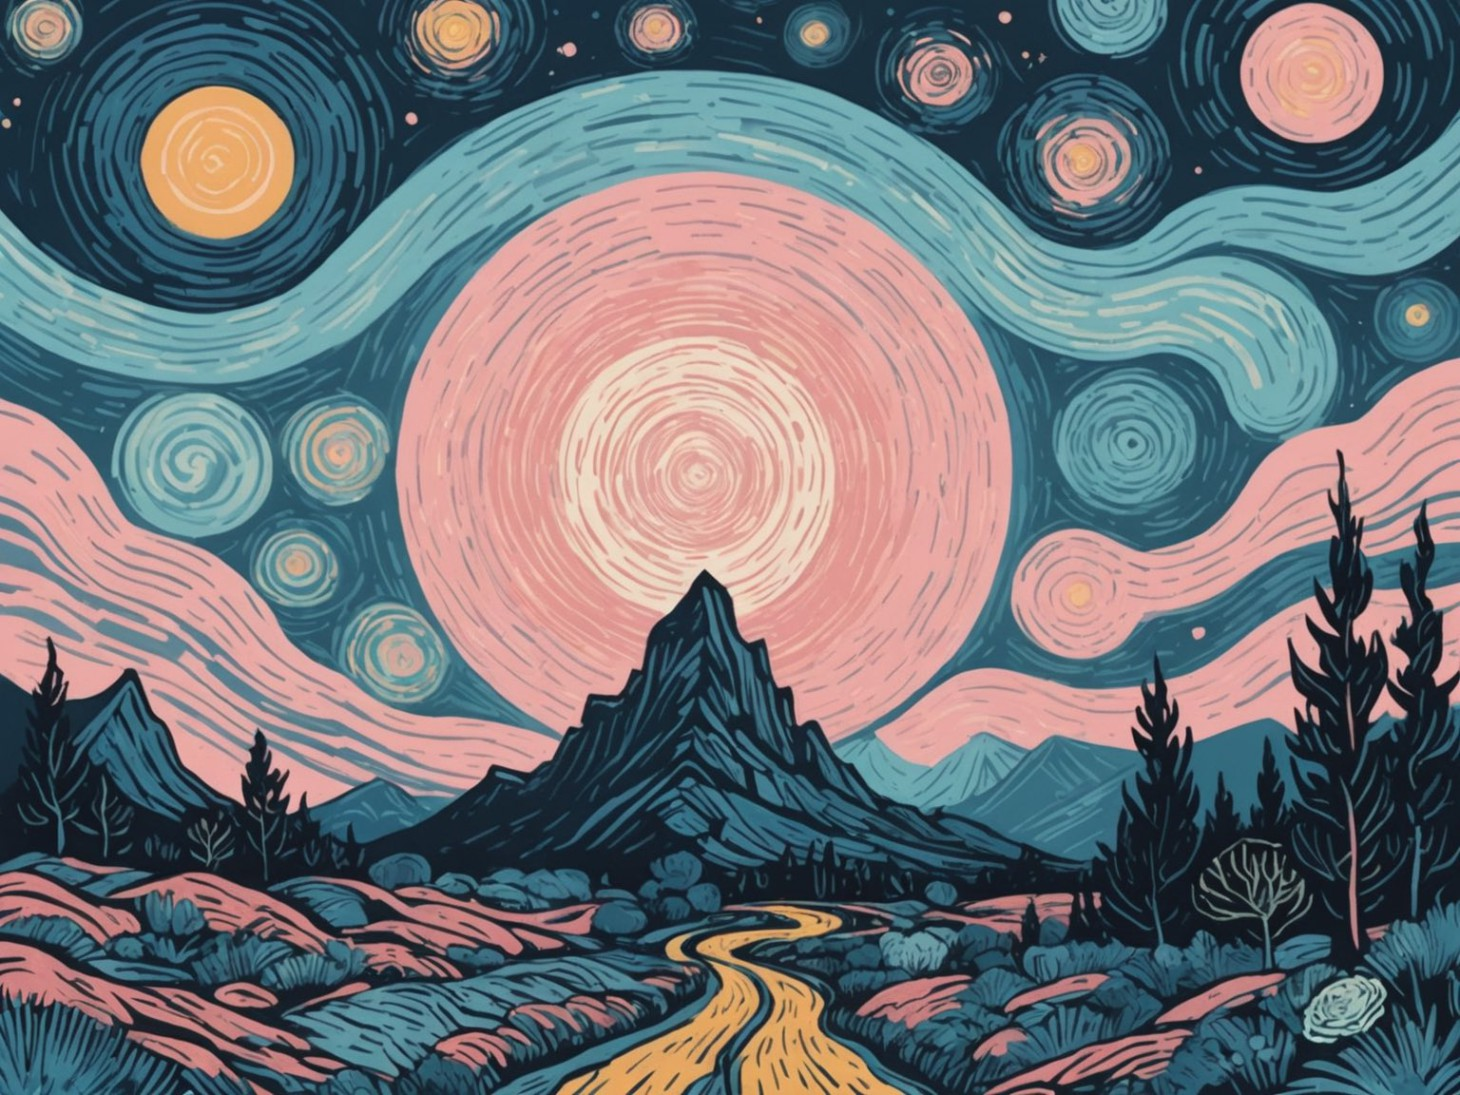

In [7]:
# load style image
#path_to_style_image = "/content/InstantStyle/assets/4.jpg"
path_to_style_image = "../assets/5.jpg"

style_image = Image.open(path_to_style_image )
style_image.resize((512, 512))
style_image


In [16]:
# input_image

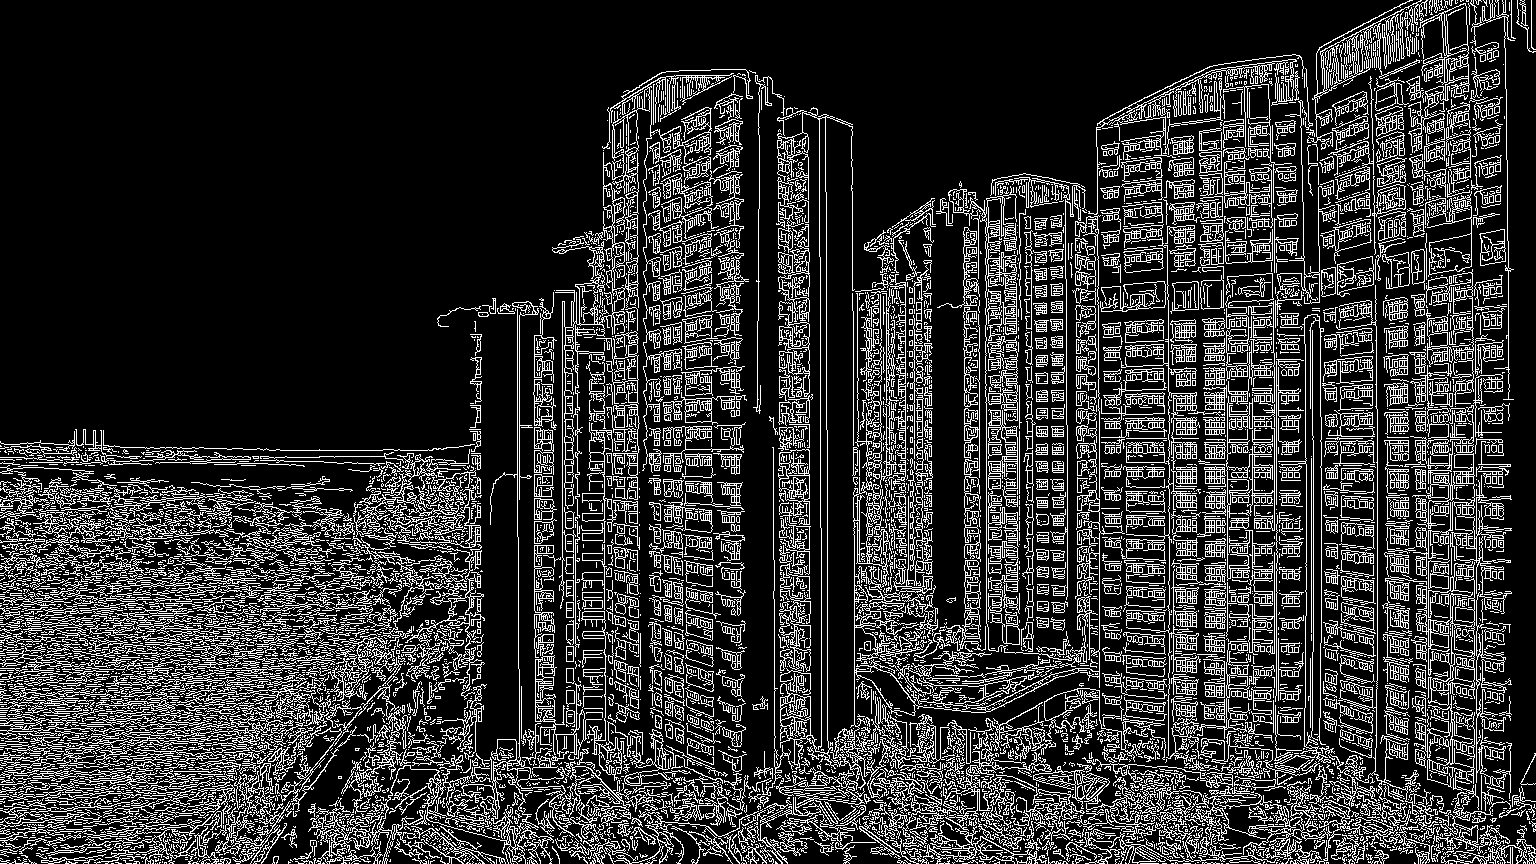

In [8]:
# setup control image
import cv2
# path_to_control_image = "../assets/yann-lecun.jpg"

path_to_control_image = "../assets/building.jpg"

input_image = cv2.imread(path_to_control_image)
detected_map = cv2.Canny(input_image, 50, 200)
canny_map = Image.fromarray(cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB))
canny_map

In [12]:
# load up the model to gpu

from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline

controlnet_path = "diffusers/controlnet-canny-sdxl-1.0"
controlnet = ControlNetModel.from_pretrained(controlnet_path, use_safetensors=False, torch_dtype=torch.float16).to(device)

# load SDXL pipeline
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    add_watermarker=False,
)
pipe.enable_vae_tiling()
#pipe.enable_sequential_cpu_offload()


# load ip-adapter
# target_blocks=["block"] for original IP-Adapter
# target_blocks=["up_blocks.0.attentions.1"] for style blocks only
# target_blocks = ["up_blocks.0.attentions.1", "down_blocks.2.attentions.1"] # for style+layout blocks
ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device, target_blocks=["up_blocks.0.attentions.1"])


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/100 [00:00<?, ?it/s]

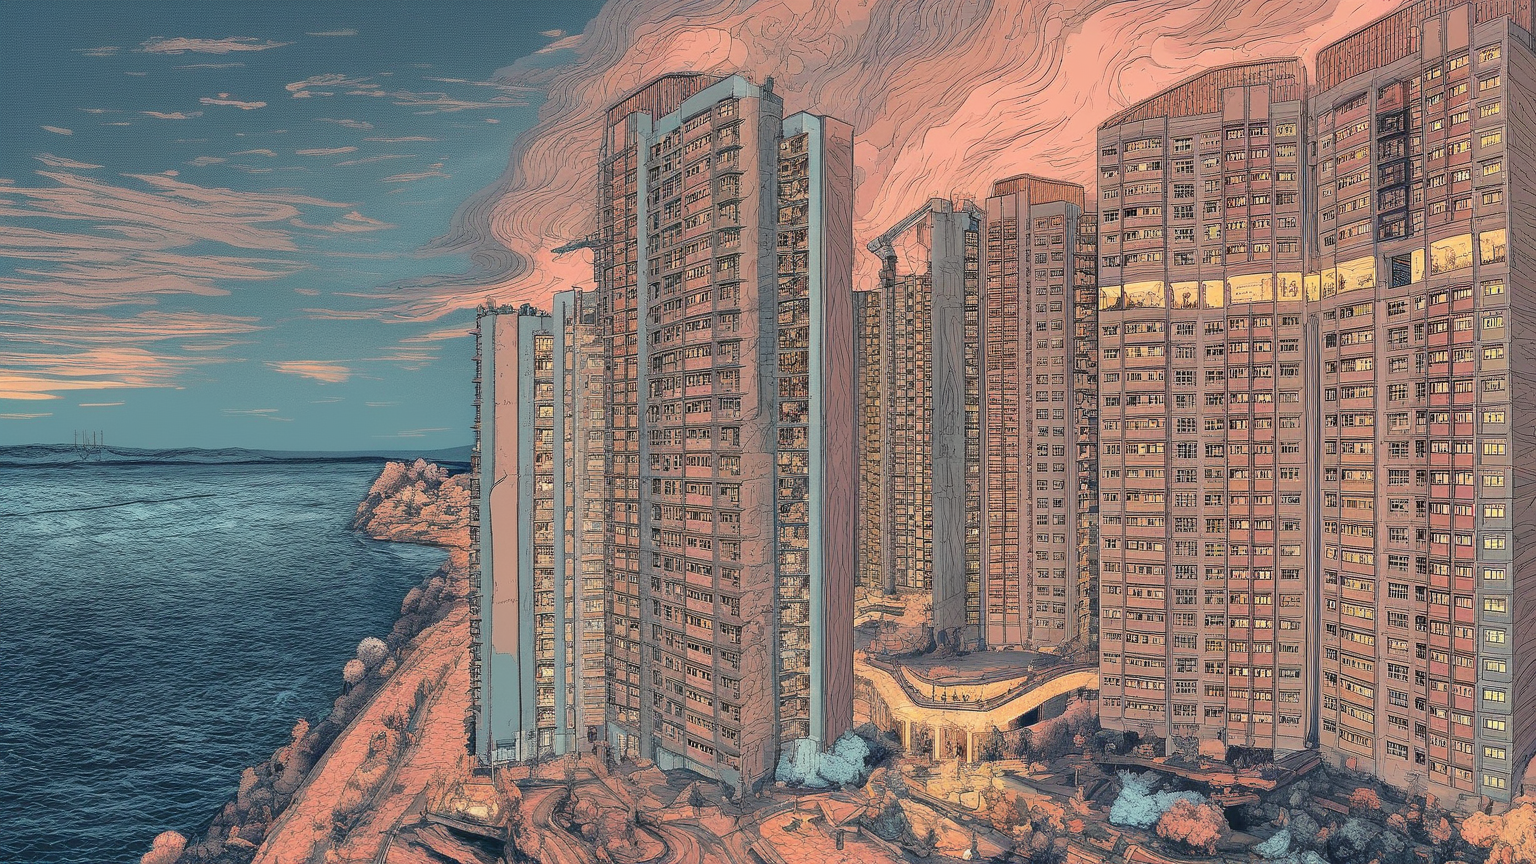

In [13]:
# generate stylished image
positive_prompt="a man, masterpiece, best quality, high quality"
negative_prompt= "text, watermark, lowres, low quality, worst quality, deformed, glitch, low contrast, noisy, saturation, blurry"

images = ip_model.generate(pil_image=style_image,
                           prompt=positive_prompt,
                           negative_prompt=negative_prompt,
                           scale=1.0,
                           guidance_scale=5,
                           seed=777,
                           num_samples=1,
                           num_inference_steps=100,
                           image=canny_map,
                           controlnet_conditioning_scale=0.6,
                          )
images[0]
